# Imports 

In [1]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

### Seed for replicational properties

In [2]:
torch.manual_seed(111)

# GPU or CPU
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Training data

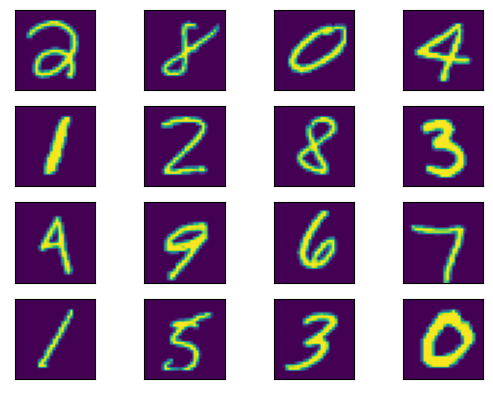

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform)

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28))
    plt.xticks([])
    plt.yticks([])

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

discriminator = Discriminator().to(device=device)

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

## Training

In [ ]:
lr = 0.0001
num_epochs = 200
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5889771580696106
Epoch: 0 Loss G.: 0.4736277759075165
Epoch: 1 Loss D.: 0.06094331666827202
Epoch: 1 Loss G.: 5.646681785583496
Epoch: 2 Loss D.: 0.05521972477436066
Epoch: 2 Loss G.: 5.326852321624756
Epoch: 3 Loss D.: 0.04278045520186424
Epoch: 3 Loss G.: 5.215598106384277
Epoch: 4 Loss D.: 0.15021733939647675
Epoch: 4 Loss G.: 5.817656517028809
Epoch: 5 Loss D.: 0.01096605695784092
Epoch: 5 Loss G.: 5.595632553100586
Epoch: 6 Loss D.: 0.10195364058017731
Epoch: 6 Loss G.: 3.848248243331909
Epoch: 7 Loss D.: 0.0594065897166729
Epoch: 7 Loss G.: 3.7994749546051025
Epoch: 8 Loss D.: 0.15992523729801178
Epoch: 8 Loss G.: 3.711686134338379
Epoch: 9 Loss D.: 0.11395362764596939
Epoch: 9 Loss G.: 2.9194529056549072
Epoch: 10 Loss D.: 0.045616112649440765
Epoch: 10 Loss G.: 4.341765880584717
Epoch: 11 Loss D.: 0.28139248490333557
Epoch: 11 Loss G.: 2.2495312690734863
Epoch: 12 Loss D.: 0.28380244970321655
Epoch: 12 Loss G.: 3.0105137825012207
Epoch: 13 Loss D.: 0.4266991

## Samples generated

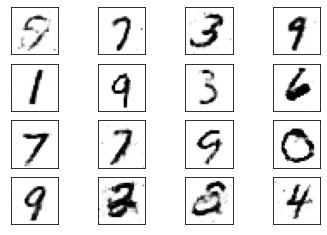

In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])